In [1]:
## Test trained GAN models 
from tensorflow.keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from numpy.random import randn
import tensorflow as tf
import cv2
import numpy as np

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Overlay trajectories (data_y) to the image (data_x)
def create_trajectory(data_x, data_y, obs_len=10):
    # Calibration parameter to overlay for a 1280x360 resolution image
    K = np.array([[537.023764, 0, 640 , 0], 
                    [0 , 537.023764, 180, 0], 
                    [0, 0, 1, 0]])
    # Rotation matrix to obtain egocentric trajectory
    Rt = np.array([[0.028841, 0.007189, 0.999558, 1.481009],
                    [-0.999575,  0.004514,  0.028809,  0.296583],
                    [ 0.004305,  0.999964, -0.007316, -1.544537],
                    [ 0.      ,  0.      ,  0.      ,  1.      ]])

    # Resize data back to 1280x360
    data_x = cv2.resize(data_x, (1280,360))
    # Add column of ones for rotation matrix multiplication
    data_y = np.hstack((data_y, np.ones((len(data_y),1))))
    # Draw points
    for m in range(obs_len, data_y.shape[0]):
        # Rotation matrix multiplication of trajectory 
        A = np.matmul(np.linalg.inv(Rt), data_y[m, :].reshape(4, 1))
        # Egocentric view of trajectory
        B = np.matmul(K, A)
        # Circle location of trajectories 
        x = int(B[0, 0] * 1.0 / B[2, 0])
        y = int(B[1, 0] * 1.0 / B[2, 0])
        if (x < 0 or x > 1280 - 1 or y > 360 - 1):
            continue
        # Use opencv to overlay trajectories
        data_x = cv2.circle(data_x, (x, y), 3, (0, 0, 255), -1)
    return data_x

In [4]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [5]:
# plot source, generated and target images
def plot_images(X_realA, X_fakeB, X_realB, filename, n_samples=1):
    X_realA = (X_realA + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    pyplot.figure(figsize=(32.0, 20.0))
    # plot real source images
    for i in range(n_samples):
        orig_image = (X_realA[i]* 255).astype(np.uint8)
        orig_image = cv2.resize(orig_image, (1280,360))
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(orig_image)
        pyplot.title(titles[i])
    # plot generated target image
    for i in range(n_samples):
        fake_sample = create_trajectory((X_realA[i]* 255).astype(np.uint8), X_fakeB[i])
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(fake_sample)
        pyplot.title(titles[1 + i])
    # plot real target image
    for i in range(n_samples):
        true_sample = create_trajectory((X_realA[i]* 255).astype(np.uint8), X_realB[i])
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(true_sample)
        pyplot.title(titles[i + 2])
    # save plot to file
    pyplot.subplots_adjust(hspace=0.4)
    pyplot.savefig(filename)
    pyplot.show()
    # save the generator model

In [6]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	return [X1, X2]

In [7]:
# load dataset
[X1, X2] = load_real_samples('dataset.npz')
print('Loaded', X1.shape, X2.shape)

Loaded (19031, 256, 256, 3) (19031, 40, 3)


In [8]:
# load model
model = load_model('./original_dataset_training_results/model_293300.h5')

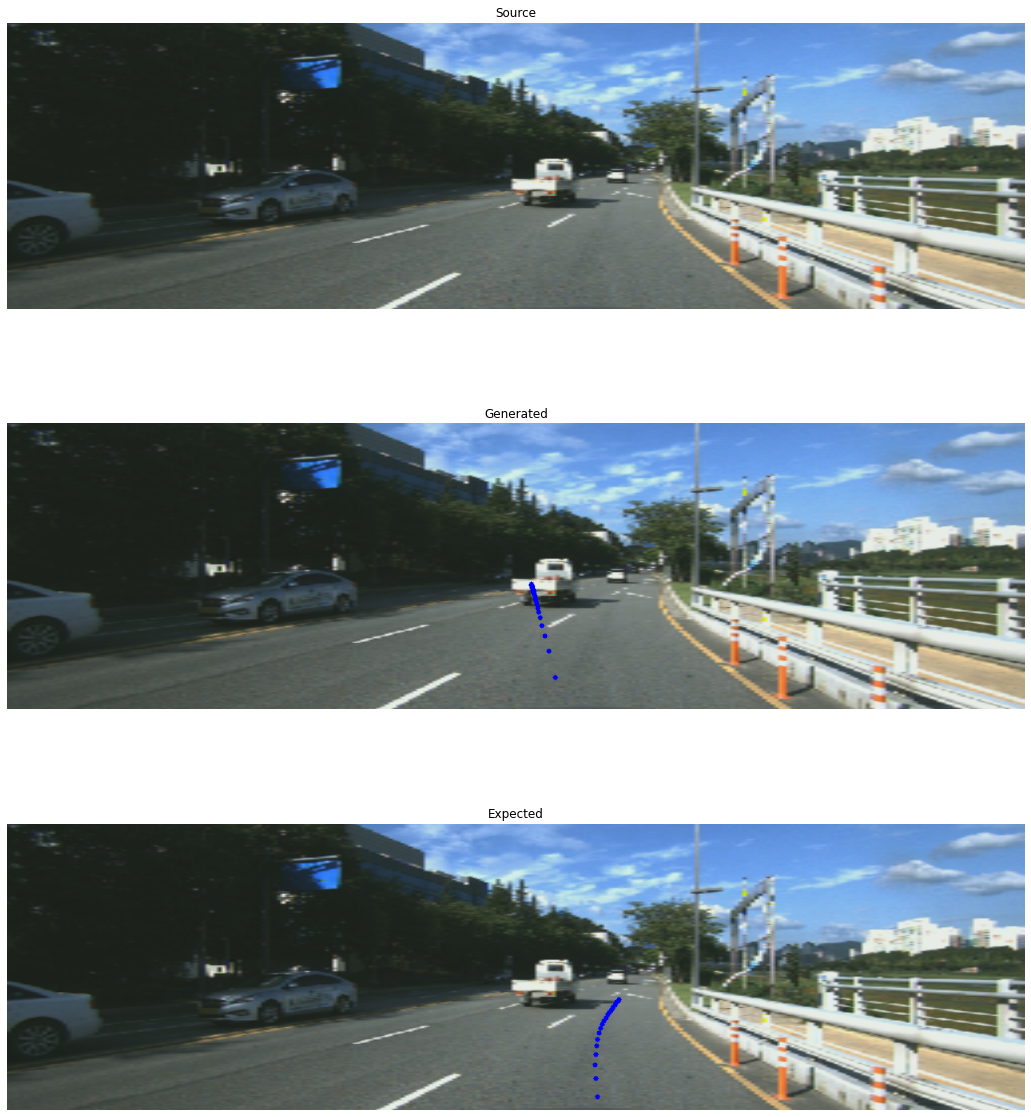

In [26]:
# select random example
latent_dim = 512
z_input = generate_latent_points(latent_dim, 1)
#ix = int(randint(0, len(X1), 1))
ix = 4290
src_image, tar_traj = X1[ix].reshape((1, 256, 256, 3)), X2[ix].reshape((1,40,3))
# generate image from source
gen_traj = model.predict([src_image, z_input])
plot_images(src_image, gen_traj, tar_traj, 'sample6.png')

In [14]:
import math
def euclidean_distance(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 + (p2[2] - p1[2])**2)

In [15]:
#params: traj1, traj2 - sets of two trajectories which the ADE is requires
#returns: Average Displacement Error between two trajectories
#brief: takes two traj. of same size, returns the average euclidean distance between all points of traj1 and traj2
def ADE(traj1, traj2):
    try:
        assert(traj1.shape == traj2.shape)
    except AssertionError:
        print("trajectory arrays differ in size!")
        return None
    dist = []
    points = len(traj1[0])
    #print(f'{points} long')
    for itr in range(points):
        p1 = traj1[0][itr]
        p2 = traj2[0][itr]
        dist.append(euclidean_distance(p1, p2))
        #print(f'traj1: {p1}, traj2: {p2}, dist: {dist[itr]}')
    ade = sum(dist)/len(dist)
    #print(ade)
    return ade

In [16]:
#params: traj1, traj2 - sets of two trajectories which the FDE is requires
#returns: Final Displacement Error between two trajectories
#brief: takes two traj. of same size, returns the euclidean distance between final points of traj1 and traj2
def FDE(traj1, traj2):
    try:
        assert(traj1.shape == traj2.shape)
    except AssertionError:
        print("trajectory arrays differ in size!")
        return None
    last_idx = len(traj1[0]) - 1
    #print(f'last index is {last_idx}')
    p1 = traj1[0][last_idx]
    p2 = traj2[0][last_idx]
    fde = euclidean_distance(p1, p2)
    #print(f'traj1: {p1}, traj2: {p2}, dist: {fde}')
    #print(fde)
    return fde

In [18]:
def get_stats(num_trajs=100, latent_dim=512, z_input=generate_latent_points(latent_dim, 1)):
    minADE = float('inf')
    minFDE = float('inf')
    avgADE = []
    avgFDE = []
    for img in range(num_trajs):
        ix = img
        src_image, tar_traj = X1[ix].reshape((1, 256, 256, 3)), X2[ix].reshape((1,40,3))
        # generate image from source
        gen_traj = model.predict([src_image, z_input])
        #plot_images(src_image, gen_traj, tar_traj, 'sample6.png')
        fde = FDE(tar_traj, gen_traj)
        ade = ADE(tar_traj, gen_traj)
        print(f'image: {img}, FDE: {fde}, ADE: {ade}')
        
        #minADE
        minADE = ade if ade < minADE else minADE
        
        #minFDE
        minFDE = fde if fde < minFDE else minFDE
        
        #avgADE
        avgADE.append(ade)
        
        #avgFDE
        avgFDE.append(fde)
        
    return(minADE, minFDE, sum(avgADE)/len(avgADE), sum(avgFDE)/len(avgFDE))

In [22]:
%%time
minADE, minFDE, avgADE, avgFDE = get_stats(num_trajs=5000)
print(f'minADE = {minADE}')
print(f'minFDE = {minFDE}')
print(f'avgADE = {avgADE}')
print(f'avgFDE = {avgFDE}')

image: 0, FDE: 0.44403657153121434, ADE: 0.1409479893309309
image: 1, FDE: 0.47325406982195345, ADE: 0.13507323882280772
image: 2, FDE: 0.40800315704457424, ADE: 0.13022562165947216
image: 3, FDE: 0.42048800849368156, ADE: 0.1327916907828045
image: 4, FDE: 0.34290190740511456, ADE: 0.11517647887395414
image: 5, FDE: 0.3959272579734515, ADE: 0.11810775401802491
image: 6, FDE: 0.4698134124400616, ADE: 0.15468864389079642
image: 7, FDE: 0.46631679359542655, ADE: 0.152847630117054
image: 8, FDE: 0.4992960346090059, ADE: 0.14899012618753313
image: 9, FDE: 0.4734987726683853, ADE: 0.14216294141216912
image: 10, FDE: 0.33709473536385337, ADE: 0.1096929630615319
image: 11, FDE: 0.35785188014320285, ADE: 0.11181790521328212
image: 12, FDE: 0.43486967459352455, ADE: 0.1218796245706915
image: 13, FDE: 0.39961905198566156, ADE: 0.11687768037565358
image: 14, FDE: 0.33521343335530995, ADE: 0.10903791352851362
image: 15, FDE: 0.31417353883410615, ADE: 0.09978608700303646
image: 16, FDE: 0.2834897743

image: 134, FDE: 0.2171813038243982, ADE: 0.057488701080837826
image: 135, FDE: 0.19875672922190402, ADE: 0.053031799352446965
image: 136, FDE: 0.24965659608140023, ADE: 0.06679199744586187
image: 137, FDE: 0.3247835943679449, ADE: 0.09574211584533583
image: 138, FDE: 0.285696967994035, ADE: 0.10399499236115346
image: 139, FDE: 0.3655751350739195, ADE: 0.11165503789487227
image: 140, FDE: 0.33680715539536854, ADE: 0.11512990264677896
image: 141, FDE: 0.27237331596801373, ADE: 0.08630786220403072
image: 142, FDE: 0.1985214715781535, ADE: 0.0784522628354104
image: 143, FDE: 0.2098625630905044, ADE: 0.06850600089092009
image: 144, FDE: 0.24589407094458487, ADE: 0.07520552646516723
image: 145, FDE: 0.25529566396322734, ADE: 0.06569738326233196
image: 146, FDE: 0.2900683366861194, ADE: 0.07895683733281056
image: 147, FDE: 0.14646747699135676, ADE: 0.03113188595017665
image: 148, FDE: 0.3677379086384668, ADE: 0.10100090014696503
image: 149, FDE: 0.22371876978963973, ADE: 0.04268654602813875


image: 271, FDE: 4.735411834712765, ADE: 1.2760664176322465
image: 272, FDE: 5.134367759034294, ADE: 1.3275757882825332
image: 273, FDE: 4.757865249767347, ADE: 1.2202705719195979
image: 274, FDE: 5.456916281492199, ADE: 1.4355905366140396
image: 275, FDE: 5.959995150316759, ADE: 1.552742442592056
image: 276, FDE: 6.591403614552229, ADE: 1.744211650608861
image: 277, FDE: 6.201587310383415, ADE: 1.6461064599044715
image: 278, FDE: 6.751526755407838, ADE: 1.8294068917231372
image: 279, FDE: 5.796633381266711, ADE: 1.5055263699489643
image: 280, FDE: 4.352179561437303, ADE: 1.1706817112962498
image: 281, FDE: 6.563371356364161, ADE: 1.8727815672398502
image: 282, FDE: 5.670018116610644, ADE: 1.6351498494806567
image: 283, FDE: 8.189363379788638, ADE: 2.4847353915771024
image: 284, FDE: 4.629278069293157, ADE: 1.2942209747598559
image: 285, FDE: 8.677726937262308, ADE: 2.6624058525998375
image: 286, FDE: 10.675561443858284, ADE: 3.554912668367023
image: 287, FDE: 7.200900041879624, ADE: 2

image: 411, FDE: 7.759237261150263, ADE: 3.535954968654102
image: 412, FDE: 8.249574663589453, ADE: 3.7453616388220565
image: 413, FDE: 9.070315200394337, ADE: 4.104400853637894
image: 414, FDE: 8.060649546856238, ADE: 3.680953871564374
image: 415, FDE: 7.880794733506069, ADE: 3.6002504922697938
image: 416, FDE: 8.321877126555165, ADE: 3.781986003950878
image: 417, FDE: 7.235748703058216, ADE: 3.3367175242733538
image: 418, FDE: 7.6158071934013485, ADE: 3.536796562177526
image: 419, FDE: 8.586314227044774, ADE: 3.889789528652725
image: 420, FDE: 9.036619463664676, ADE: 4.0423907825954455
image: 421, FDE: 9.223223042932704, ADE: 4.162517674484268
image: 422, FDE: 9.605322720825072, ADE: 4.284600530405027
image: 423, FDE: 9.099362686476594, ADE: 4.0400789888204764
image: 424, FDE: 8.26197416229929, ADE: 3.687204829774869
image: 425, FDE: 9.234882528486152, ADE: 4.100680630211866
image: 426, FDE: 9.509102885944808, ADE: 4.170979039244627
image: 427, FDE: 10.002598877131408, ADE: 4.4076782

image: 553, FDE: 4.763422159610185, ADE: 2.0799526649050257
image: 554, FDE: 4.787230082474018, ADE: 2.015081514937024
image: 555, FDE: 4.273670133111407, ADE: 1.7998210702429727
image: 556, FDE: 3.6015024577643415, ADE: 1.6308295787342633
image: 557, FDE: 2.9821447163210175, ADE: 1.289045223170596
image: 558, FDE: 1.4809998043265589, ADE: 0.6729422803553636
image: 559, FDE: 2.530783432195083, ADE: 1.123978815434506
image: 560, FDE: 5.789161549102104, ADE: 2.511922091930768
image: 561, FDE: 5.328702135609101, ADE: 2.3597994514567375
image: 562, FDE: 4.4213237020799685, ADE: 1.9821790538575104
image: 563, FDE: 5.570881251438451, ADE: 2.4897574483031835
image: 564, FDE: 5.519514730978056, ADE: 2.485611983158001
image: 565, FDE: 5.818558543778802, ADE: 2.6829891372549333
image: 566, FDE: 6.7648412030032885, ADE: 3.0851029101405834
image: 567, FDE: 5.945051608748279, ADE: 2.8379591087852942
image: 568, FDE: 6.731644756101108, ADE: 3.1958738002389167
image: 569, FDE: 5.029676199424618, ADE:

image: 693, FDE: 40.07682296954895, ADE: 16.895998599352296
image: 694, FDE: 40.04591461795115, ADE: 16.885514583310403
image: 695, FDE: 40.084615135594774, ADE: 16.887872908126063
image: 696, FDE: 40.352493945850476, ADE: 16.9972044348608
image: 697, FDE: 40.666249253382965, ADE: 17.1242451275398
image: 698, FDE: 40.53477882530186, ADE: 17.092396947135498
image: 699, FDE: 40.70289737200238, ADE: 17.12580337244148
image: 700, FDE: 41.05731299438465, ADE: 17.240100105009482
image: 701, FDE: 41.30473167707898, ADE: 17.334049472965678
image: 702, FDE: 40.93255504219112, ADE: 17.16884999101799
image: 703, FDE: 40.436636760211286, ADE: 16.965484623625628
image: 704, FDE: 40.15580996792853, ADE: 16.86477459298845
image: 705, FDE: 40.076558256419354, ADE: 16.833231250430806
image: 706, FDE: 40.40188569780552, ADE: 16.972207678233946
image: 707, FDE: 40.37963316879297, ADE: 16.960922866560274
image: 708, FDE: 40.15653658067758, ADE: 16.862111371674906
image: 709, FDE: 40.26511808804471, ADE: 1

image: 837, FDE: 12.018736543075422, ADE: 5.298904699754277
image: 838, FDE: 10.759400137088429, ADE: 4.724782780327867
image: 839, FDE: 11.644211749289248, ADE: 5.074967394554421
image: 840, FDE: 10.985795428728315, ADE: 4.823611374661928
image: 841, FDE: 11.078946963500812, ADE: 4.890889235797378
image: 842, FDE: 11.164745820341466, ADE: 4.891665546100947
image: 843, FDE: 7.9523201031123385, ADE: 3.497357861937181
image: 844, FDE: 6.328858070053631, ADE: 2.7946720795319773
image: 845, FDE: 7.772970737087291, ADE: 3.4318308713082346
image: 846, FDE: 10.860339289296897, ADE: 4.802183933047973
image: 847, FDE: 9.375219406957251, ADE: 4.2491103439112745
image: 848, FDE: 9.071832330547211, ADE: 4.09459663486321
image: 849, FDE: 9.691677477636848, ADE: 4.408670919991756
image: 850, FDE: 10.138371769080118, ADE: 4.62298530852051
image: 851, FDE: 11.239662463079057, ADE: 5.149245861136104
image: 852, FDE: 10.63819581164711, ADE: 4.916527215448669
image: 853, FDE: 10.589929533900941, ADE: 4.9

image: 977, FDE: 35.01508596829774, ADE: 15.370269891893248
image: 978, FDE: 34.99424267072629, ADE: 15.392862086505996
image: 979, FDE: 34.96066482034295, ADE: 15.40100331109023
image: 980, FDE: 34.35322117694382, ADE: 15.15553623609198
image: 981, FDE: 34.341558172926014, ADE: 15.170495780651626
image: 982, FDE: 34.98563829569386, ADE: 15.438959253440412
image: 983, FDE: 33.915066518192354, ADE: 14.992376256841075
image: 984, FDE: 35.8058304172449, ADE: 15.77150317669217
image: 985, FDE: 36.47570199969154, ADE: 16.062378551393586
image: 986, FDE: 35.73043203319125, ADE: 15.7190468392142
image: 987, FDE: 35.496920202142356, ADE: 15.621564191456196
image: 988, FDE: 35.698349305982426, ADE: 15.67593607360501
image: 989, FDE: 33.07819627408418, ADE: 14.587626473133259
image: 990, FDE: 34.036930116526776, ADE: 14.995012742011976
image: 991, FDE: 33.69487098533366, ADE: 14.863876897943195
image: 992, FDE: 33.349698493140025, ADE: 14.735890828712982
image: 993, FDE: 31.35772459077134, ADE: 

image: 1111, FDE: 1.4764695229979299, ADE: 1.095073149425117
image: 1112, FDE: 3.0671496771961593, ADE: 1.7726786787859408
image: 1113, FDE: 2.114646336932077, ADE: 1.394511051409927
image: 1114, FDE: 1.0180592746811692, ADE: 0.8889246740446012
image: 1115, FDE: 1.2774759847245762, ADE: 0.6841496675002151
image: 1116, FDE: 1.7311880328580354, ADE: 0.6823464363459637
image: 1117, FDE: 2.2282874351650173, ADE: 0.6027166342117095
image: 1118, FDE: 1.7196973020703625, ADE: 0.6872548423962284
image: 1119, FDE: 2.5804831921432663, ADE: 0.6777424118276983
image: 1120, FDE: 3.8512763195290383, ADE: 0.888459677118073
image: 1121, FDE: 3.883668379961849, ADE: 0.912965908852217
image: 1122, FDE: 3.61088343987097, ADE: 0.8635835002718057
image: 1123, FDE: 4.412704681523483, ADE: 1.0546186502141712
image: 1124, FDE: 4.932192948702422, ADE: 1.2095743932787169
image: 1125, FDE: 4.815921020771674, ADE: 1.175796116192569
image: 1126, FDE: 5.452381946929686, ADE: 1.3615541842577819
image: 1127, FDE: 5.8

image: 1251, FDE: 43.90312374467687, ADE: 18.50882189699148
image: 1252, FDE: 44.249109383195474, ADE: 18.655242722122335
image: 1253, FDE: 44.33112743505343, ADE: 18.69826934527199
image: 1254, FDE: 44.24094784167476, ADE: 18.644788808354164
image: 1255, FDE: 44.22361861410087, ADE: 18.629613443595968
image: 1256, FDE: 44.21516914487259, ADE: 18.62537229122801
image: 1257, FDE: 44.12292197895603, ADE: 18.575582010490443
image: 1258, FDE: 44.249117505484335, ADE: 18.63695213231104
image: 1259, FDE: 44.262099900948, ADE: 18.649391876447847
image: 1260, FDE: 44.74338537859223, ADE: 18.857073856314223
image: 1261, FDE: 44.616712865464095, ADE: 18.788427016220133
image: 1262, FDE: 44.479117175766596, ADE: 18.736403813124934
image: 1263, FDE: 44.400783769407184, ADE: 18.69321567464341
image: 1264, FDE: 44.370235674340414, ADE: 18.677022449019404
image: 1265, FDE: 44.66943928005005, ADE: 18.802494572355517
image: 1266, FDE: 44.50122153036153, ADE: 18.733042991611956
image: 1267, FDE: 44.5025

image: 1390, FDE: 20.44318791770233, ADE: 9.045460582414387
image: 1391, FDE: 17.539046130066794, ADE: 7.893150496822227
image: 1392, FDE: 19.439100742555347, ADE: 8.690885570569842
image: 1393, FDE: 20.163715462103646, ADE: 8.969640189233015
image: 1394, FDE: 19.958659834724763, ADE: 8.874625268404513
image: 1395, FDE: 19.09272729456775, ADE: 8.601341662529506
image: 1396, FDE: 19.20299944591866, ADE: 8.569789757632723
image: 1397, FDE: 18.597358290899933, ADE: 8.35444286338974
image: 1398, FDE: 18.9814946794514, ADE: 8.493685427309128
image: 1399, FDE: 16.418888312664798, ADE: 7.463143038489937
image: 1400, FDE: 15.940683367662768, ADE: 7.2603004905072055
image: 1401, FDE: 16.42846721495116, ADE: 7.533308882080315
image: 1402, FDE: 15.75867121120275, ADE: 7.21499133455531
image: 1403, FDE: 16.82123782712447, ADE: 7.60765523215788
image: 1404, FDE: 17.996217266069895, ADE: 8.127906910894993
image: 1405, FDE: 16.00680161229869, ADE: 7.242977985486884
image: 1406, FDE: 16.09537024423619

image: 1530, FDE: 13.121063032621715, ADE: 5.32438107332005
image: 1531, FDE: 13.328986533382848, ADE: 5.390468487729162
image: 1532, FDE: 12.66595660970067, ADE: 5.152790000751201
image: 1533, FDE: 11.830663191362312, ADE: 4.812504420969065
image: 1534, FDE: 12.50933934836455, ADE: 5.027073779921423
image: 1535, FDE: 10.912666656078866, ADE: 4.330370847335887
image: 1536, FDE: 12.683516446630508, ADE: 5.056664370930466
image: 1537, FDE: 12.556974192859148, ADE: 5.012121804798867
image: 1538, FDE: 14.210372157265052, ADE: 5.698097817581325
image: 1539, FDE: 13.679444437635974, ADE: 5.440296129129927
image: 1540, FDE: 13.768056467507149, ADE: 5.49638658552644
image: 1541, FDE: 13.922839043332742, ADE: 5.541750509564717
image: 1542, FDE: 14.411452296986317, ADE: 5.746572012431736
image: 1543, FDE: 14.146266663338833, ADE: 5.656029942103649
image: 1544, FDE: 13.428220414571593, ADE: 5.331013012074078
image: 1545, FDE: 14.005400905761524, ADE: 5.601721498362313
image: 1546, FDE: 13.4500011

image: 1670, FDE: 2.058945378942123, ADE: 0.8656949024766865
image: 1671, FDE: 1.7377900655419098, ADE: 0.7379648533927317
image: 1672, FDE: 3.066299600152665, ADE: 1.3019863921754165
image: 1673, FDE: 3.9968109607411826, ADE: 1.707441097440644
image: 1674, FDE: 4.029492940240662, ADE: 1.7086338074028746
image: 1675, FDE: 3.4384296538721895, ADE: 1.4419081633292175
image: 1676, FDE: 3.9839868904855518, ADE: 1.6681373282516372
image: 1677, FDE: 4.058371283588925, ADE: 1.6952105264963706
image: 1678, FDE: 3.5898901743396445, ADE: 1.5208576152023616
image: 1679, FDE: 4.983003192657497, ADE: 2.1196708266903763
image: 1680, FDE: 5.803113581977674, ADE: 2.4271115048329928
image: 1681, FDE: 5.239412531243266, ADE: 2.169152378639386
image: 1682, FDE: 4.634885848991695, ADE: 1.9322912154874614
image: 1683, FDE: 5.687527130508945, ADE: 2.3734454706043375
image: 1684, FDE: 5.1968483972171935, ADE: 2.166797241903103
image: 1685, FDE: 5.716099820347527, ADE: 2.3705426329584722
image: 1686, FDE: 5.7

image: 1810, FDE: 4.776744864755776, ADE: 1.6648567071132923
image: 1811, FDE: 3.944267263339271, ADE: 1.2974205688175622
image: 1812, FDE: 4.5440531843153265, ADE: 1.549648992901597
image: 1813, FDE: 5.349408809672862, ADE: 1.9000476221033054
image: 1814, FDE: 6.5007965264836605, ADE: 2.403433224627689
image: 1815, FDE: 5.752078797007677, ADE: 2.0847644210878924
image: 1816, FDE: 4.214522042382898, ADE: 1.4215393221051111
image: 1817, FDE: 3.6156054924756926, ADE: 1.1771796201070752
image: 1818, FDE: 4.244624924424067, ADE: 1.4102955136594328
image: 1819, FDE: 3.187300250314688, ADE: 0.9924353956625085
image: 1820, FDE: 4.245074810624252, ADE: 1.4358196157914542
image: 1821, FDE: 3.8658646653827824, ADE: 1.2786413604981182
image: 1822, FDE: 4.351668692047856, ADE: 1.4756999815752625
image: 1823, FDE: 4.378651166062984, ADE: 1.5322897511338986
image: 1824, FDE: 4.8807476849729605, ADE: 1.7223050802778714
image: 1825, FDE: 5.272675929706514, ADE: 1.9305361608967417
image: 1826, FDE: 6.8

image: 1947, FDE: 20.073973093245854, ADE: 8.57029692844725
image: 1948, FDE: 20.727054904206746, ADE: 8.877190728408115
image: 1949, FDE: 21.83662925112624, ADE: 9.34384670948322
image: 1950, FDE: 17.36753987936691, ADE: 7.421667734541797
image: 1951, FDE: 19.27269336103591, ADE: 8.305250431151581
image: 1952, FDE: 24.05285493468484, ADE: 10.289617103708428
image: 1953, FDE: 24.184658632488624, ADE: 10.320475205603339
image: 1954, FDE: 25.16477975392625, ADE: 10.725227410584584
image: 1955, FDE: 23.70537593531891, ADE: 10.07108221366379
image: 1956, FDE: 22.455150835391244, ADE: 9.50245823922037
image: 1957, FDE: 24.240672800378896, ADE: 10.270776412860306
image: 1958, FDE: 23.940987443583552, ADE: 10.113245586216472
image: 1959, FDE: 24.085238115516965, ADE: 10.186484155605404
image: 1960, FDE: 24.740852195159203, ADE: 10.447428263139763
image: 1961, FDE: 23.69602587422813, ADE: 9.950543791636644
image: 1962, FDE: 22.28330670055414, ADE: 9.32520601599161
image: 1963, FDE: 22.41276642

image: 2087, FDE: 1.6398774885381382, ADE: 0.4926438312050113
image: 2088, FDE: 1.342274517455954, ADE: 0.4075500642875129
image: 2089, FDE: 1.665668482467422, ADE: 0.5269830877246572
image: 2090, FDE: 1.666820223368568, ADE: 0.5526383864465515
image: 2091, FDE: 1.98249069589023, ADE: 0.6375556888310652
image: 2092, FDE: 2.15368404597826, ADE: 0.6927954761368136
image: 2093, FDE: 1.7958827426308028, ADE: 0.5486885023840354
image: 2094, FDE: 1.8937530101108926, ADE: 0.5961864333191172
image: 2095, FDE: 1.554049915202096, ADE: 0.4735548081125371
image: 2096, FDE: 1.4683612994536464, ADE: 0.4157904155174402
image: 2097, FDE: 1.55247928265829, ADE: 0.4645393590976341
image: 2098, FDE: 1.1352405855490137, ADE: 0.40393264065632717
image: 2099, FDE: 1.2442235764193186, ADE: 0.45321207680830256
image: 2100, FDE: 1.5201552836533605, ADE: 0.4924864540420238
image: 2101, FDE: 2.2194400939279415, ADE: 0.8104654390821386
image: 2102, FDE: 2.014282015082097, ADE: 0.7093896748707966
image: 2103, FDE:

image: 2227, FDE: 1.671641050174793, ADE: 0.6630462232935941
image: 2228, FDE: 1.911458092184375, ADE: 0.7888842149501046
image: 2229, FDE: 2.426676538375655, ADE: 0.9651461065639475
image: 2230, FDE: 3.463321991293863, ADE: 1.3990586364962452
image: 2231, FDE: 4.532434744454305, ADE: 1.7918585415733397
image: 2232, FDE: 4.722366395578062, ADE: 1.7477888827833894
image: 2233, FDE: 3.814944428339778, ADE: 1.4868718449011142
image: 2234, FDE: 3.7703541871972943, ADE: 1.4443179110114044
image: 2235, FDE: 5.057617204657427, ADE: 1.9526161213735342
image: 2236, FDE: 4.558897061637361, ADE: 1.7363871715332748
image: 2237, FDE: 4.886734674387178, ADE: 1.866595613391457
image: 2238, FDE: 5.367039454457135, ADE: 2.055099504444315
image: 2239, FDE: 5.093138387259624, ADE: 1.931211191139137
image: 2240, FDE: 4.8760887970659095, ADE: 1.8468813465080296
image: 2241, FDE: 5.571303346239458, ADE: 2.1420074557541273
image: 2242, FDE: 7.27122937267173, ADE: 2.859420328208819
image: 2243, FDE: 5.5088318

image: 2367, FDE: 5.153121709888018, ADE: 1.7832966169150073
image: 2368, FDE: 1.768554766418973, ADE: 0.9495900318368014
image: 2369, FDE: 3.3552132482276305, ADE: 1.6304680978852857
image: 2370, FDE: 4.265548104362224, ADE: 2.039928413900294
image: 2371, FDE: 2.6401383996929613, ADE: 1.3271185465175037
image: 2372, FDE: 3.669774543929395, ADE: 1.280240988661537
image: 2373, FDE: 2.9053785468572926, ADE: 0.9425741086283959
image: 2374, FDE: 1.9972656837891531, ADE: 1.1227508342779529
image: 2375, FDE: 2.079412627745585, ADE: 1.0828761388972834
image: 2376, FDE: 2.7298737774834834, ADE: 0.9097887258677704
image: 2377, FDE: 1.6864956342383597, ADE: 0.8110126220049745
image: 2378, FDE: 3.9681941825310063, ADE: 1.3496101788827546
image: 2379, FDE: 4.006256305771814, ADE: 1.3740493784992283
image: 2380, FDE: 5.111436807516195, ADE: 1.7703342811672211
image: 2381, FDE: 13.277103934710683, ADE: 5.23879777447422
image: 2382, FDE: 12.222300321606385, ADE: 4.804476173930137
image: 2383, FDE: 6.

image: 2504, FDE: 23.759477395238715, ADE: 9.747486035496712
image: 2505, FDE: 23.894910160171506, ADE: 9.768114907132391
image: 2506, FDE: 23.656860899301265, ADE: 9.646855237301512
image: 2507, FDE: 23.55769212173804, ADE: 9.629031976148948
image: 2508, FDE: 23.34076209876287, ADE: 9.513453456067634
image: 2509, FDE: 23.87143949264865, ADE: 9.687775272218797
image: 2510, FDE: 23.806813133548257, ADE: 9.666942606404398
image: 2511, FDE: 24.149121122530165, ADE: 9.790662884445412
image: 2512, FDE: 24.261968777765016, ADE: 9.841345532567722
image: 2513, FDE: 24.12186670235671, ADE: 9.772112695391318
image: 2514, FDE: 23.739213418624868, ADE: 9.622352941781937
image: 2515, FDE: 24.503487134091426, ADE: 9.923681866689558
image: 2516, FDE: 24.834183048203617, ADE: 10.063928577425248
image: 2517, FDE: 24.68552511525378, ADE: 10.00058353031946
image: 2518, FDE: 24.754460916576516, ADE: 10.03402275218157
image: 2519, FDE: 24.94630032286072, ADE: 10.12502940281251
image: 2520, FDE: 25.02296638

image: 2644, FDE: 38.13074149921899, ADE: 15.973134905009962
image: 2645, FDE: 38.22153033534076, ADE: 15.991523680164178
image: 2646, FDE: 38.42462260826653, ADE: 16.07063216094191
image: 2647, FDE: 38.34632680748211, ADE: 16.01755174192701
image: 2648, FDE: 38.68058320559533, ADE: 16.1408302662463
image: 2649, FDE: 38.907084320827806, ADE: 16.231479268559816
image: 2650, FDE: 38.99076026695649, ADE: 16.246936125430913
image: 2651, FDE: 39.05335851648393, ADE: 16.269117381665822
image: 2652, FDE: 38.87212215228365, ADE: 16.204380965443484
image: 2653, FDE: 39.01726065896675, ADE: 16.25110092364708
image: 2654, FDE: 38.99469860147794, ADE: 16.241278479948924
image: 2655, FDE: 39.24635128878716, ADE: 16.32951356540363
image: 2656, FDE: 39.19638515417703, ADE: 16.311009015188112
image: 2657, FDE: 39.32508968055784, ADE: 16.351907314859
image: 2658, FDE: 39.74840502565489, ADE: 16.513713869497572
image: 2659, FDE: 39.83609774828074, ADE: 16.566046475649095
image: 2660, FDE: 39.91982565638

image: 2784, FDE: 16.439514111317276, ADE: 7.398557529309571
image: 2785, FDE: 18.261408358512668, ADE: 8.05342167184521
image: 2786, FDE: 17.089272970174715, ADE: 7.573700272862789
image: 2787, FDE: 18.524417100646062, ADE: 8.12312909056413
image: 2788, FDE: 18.28390849479613, ADE: 8.003961823585636
image: 2789, FDE: 18.340536857032934, ADE: 8.000120833357546
image: 2790, FDE: 17.700567704556708, ADE: 7.688870824138223
image: 2791, FDE: 17.904175902580793, ADE: 7.839958079691433
image: 2792, FDE: 17.882353941186683, ADE: 7.816504051810531
image: 2793, FDE: 16.61949926893261, ADE: 7.233742868260987
image: 2794, FDE: 15.599711135875966, ADE: 6.822313549842063
image: 2795, FDE: 15.856991131935931, ADE: 6.897319780497021
image: 2796, FDE: 16.20162009874085, ADE: 7.050322016871851
image: 2797, FDE: 16.06120148824356, ADE: 6.994899969999409
image: 2798, FDE: 16.999956133775925, ADE: 7.290793824002816
image: 2799, FDE: 17.31763134762515, ADE: 7.357455994816222
image: 2800, FDE: 17.4230454203

image: 2922, FDE: 30.798642271645516, ADE: 12.849329235550107
image: 2923, FDE: 30.535034689022076, ADE: 12.770749453162427
image: 2924, FDE: 29.836937510403047, ADE: 12.397075233913169
image: 2925, FDE: 27.986687114012945, ADE: 11.664406442465117
image: 2926, FDE: 29.649313991680017, ADE: 12.301141345849059
image: 2927, FDE: 29.004559579458466, ADE: 12.087870142434564
image: 2928, FDE: 29.29910995949193, ADE: 12.22873845334768
image: 2929, FDE: 29.39331465315394, ADE: 12.275389679770827
image: 2930, FDE: 28.879346899041046, ADE: 12.082665282764733
image: 2931, FDE: 27.421268542224496, ADE: 11.485906640232697
image: 2932, FDE: 26.96455019136849, ADE: 11.30428550200005
image: 2933, FDE: 26.93896210907127, ADE: 11.25256776064604
image: 2934, FDE: 27.371020671186066, ADE: 11.46999188124983
image: 2935, FDE: 25.57683529518042, ADE: 10.839472666510899
image: 2936, FDE: 21.92538782387322, ADE: 9.397069448702082
image: 2937, FDE: 21.124303065124984, ADE: 9.04622757303206
image: 2938, FDE: 23.

image: 3062, FDE: 34.10341536577532, ADE: 14.203134040528841
image: 3063, FDE: 33.08299247105117, ADE: 13.767748566217344
image: 3064, FDE: 29.076551855078414, ADE: 12.042764776670861
image: 3065, FDE: 30.310277829598657, ADE: 12.543026254893526
image: 3066, FDE: 29.624839557207654, ADE: 12.278340923565592
image: 3067, FDE: 28.505748306950586, ADE: 11.830454262408326
image: 3068, FDE: 29.11326434300044, ADE: 12.101968133897804
image: 3069, FDE: 31.21219981113954, ADE: 12.944649598794555
image: 3070, FDE: 32.28139355194611, ADE: 13.383063394906122
image: 3071, FDE: 35.4624571538818, ADE: 14.76720595058509
image: 3072, FDE: 38.83584648293306, ADE: 16.241240296405802
image: 3073, FDE: 39.94389396117334, ADE: 16.705692286346125
image: 3074, FDE: 32.394535075455984, ADE: 12.802620196124556
image: 3075, FDE: 32.88145782064459, ADE: 13.056676864721547
image: 3076, FDE: 32.63667823751191, ADE: 13.015248266923166
image: 3077, FDE: 32.781286381313926, ADE: 13.09796272073524
image: 3078, FDE: 32.

image: 3202, FDE: 6.838486637213672, ADE: 2.933850536640758
image: 3203, FDE: 7.095607553130038, ADE: 3.018720128057601
image: 3204, FDE: 6.736244776512801, ADE: 2.8832782204738416
image: 3205, FDE: 6.781081895132291, ADE: 2.8901687683956774
image: 3206, FDE: 7.011462590989719, ADE: 2.9801060953956604
image: 3207, FDE: 6.881857349265019, ADE: 2.922085199528873
image: 3208, FDE: 7.15030658141598, ADE: 3.002656440927187
image: 3209, FDE: 7.8013377539901665, ADE: 3.2687591731322074
image: 3210, FDE: 7.432130536947349, ADE: 3.091421348871545
image: 3211, FDE: 7.140985718361467, ADE: 2.9942491015782813
image: 3212, FDE: 6.9646349187657215, ADE: 2.888260416461655
image: 3213, FDE: 7.372117854623885, ADE: 3.045005885409668
image: 3214, FDE: 7.4357345027947215, ADE: 3.091652170604243
image: 3215, FDE: 7.39312934560846, ADE: 3.1118201970532664
image: 3216, FDE: 7.545221697367151, ADE: 3.1649421847556103
image: 3217, FDE: 7.8221877613976085, ADE: 3.290426798908895
image: 3218, FDE: 7.65342979686

image: 3342, FDE: 7.1216395421270375, ADE: 2.9916301155355134
image: 3343, FDE: 8.765766280017758, ADE: 3.7949169508783314
image: 3344, FDE: 12.350124773303698, ADE: 5.4139422617932755
image: 3345, FDE: 9.262127358634347, ADE: 3.972197334523384
image: 3346, FDE: 11.737877567825004, ADE: 5.0776910533884
image: 3347, FDE: 23.92418849683517, ADE: 10.10959288452292
image: 3348, FDE: 25.01778246234063, ADE: 10.589319255688181
image: 3349, FDE: 25.591947874862274, ADE: 10.833545760300307
image: 3350, FDE: 26.17745800312726, ADE: 11.087546701597342
image: 3351, FDE: 25.719522498135106, ADE: 10.916921822039122
image: 3352, FDE: 24.322989524303942, ADE: 10.401485686008158
image: 3353, FDE: 23.865857239804345, ADE: 10.258013845105591
image: 3354, FDE: 23.715024677706925, ADE: 10.155077686441505
image: 3355, FDE: 22.729760695026098, ADE: 9.782507550830934
image: 3356, FDE: 23.253282233559855, ADE: 10.02744945228727
image: 3357, FDE: 24.170430096281976, ADE: 10.43484665258325
image: 3358, FDE: 24.

image: 3481, FDE: 21.262447149100215, ADE: 8.56125002704538
image: 3482, FDE: 21.950806476892367, ADE: 8.859800257823647
image: 3483, FDE: 22.047246777407718, ADE: 8.907379489264382
image: 3484, FDE: 21.590293032432765, ADE: 8.736879598418245
image: 3485, FDE: 21.311001215976844, ADE: 8.632633400298829
image: 3486, FDE: 21.37250371303729, ADE: 8.684119468843628
image: 3487, FDE: 19.670310027509, ADE: 7.981357010332897
image: 3488, FDE: 18.354440007797873, ADE: 7.44741849002529
image: 3489, FDE: 16.503738361476632, ADE: 6.653183978506744
image: 3490, FDE: 15.23186961647963, ADE: 6.150142365537095
image: 3491, FDE: 15.683309633330785, ADE: 6.335488471870172
image: 3492, FDE: 15.580067893950984, ADE: 6.247450064906701
image: 3493, FDE: 14.257308479706415, ADE: 5.6711115032431465
image: 3494, FDE: 13.363161555988418, ADE: 5.3356475572705815
image: 3495, FDE: 15.803277913289826, ADE: 6.320915830357637
image: 3496, FDE: 15.893226905152908, ADE: 6.363128517878134
image: 3497, FDE: 14.78250495

image: 3621, FDE: 32.308053548981114, ADE: 13.24197055240477
image: 3622, FDE: 30.586191743743807, ADE: 12.269256939319156
image: 3623, FDE: 35.398335577528975, ADE: 14.252444786948661
image: 3624, FDE: 36.845469745987636, ADE: 14.887361521252256
image: 3625, FDE: 40.157883287836704, ADE: 16.36109559781927
image: 3626, FDE: 39.441497063575035, ADE: 16.127216772646378
image: 3627, FDE: 38.08598971543786, ADE: 15.606887759377722
image: 3628, FDE: 41.23866404032086, ADE: 16.939325411162145
image: 3629, FDE: 40.95411350473724, ADE: 16.839633250812437
image: 3630, FDE: 37.48153095188992, ADE: 15.454569079149158
image: 3631, FDE: 34.45871077005762, ADE: 14.247956754032248
image: 3632, FDE: 33.77078270759062, ADE: 13.951272102596082
image: 3633, FDE: 34.50925990244478, ADE: 14.20405288517188
image: 3634, FDE: 35.03296785192433, ADE: 14.347140531346202
image: 3635, FDE: 37.6134266632043, ADE: 15.443139743061362
image: 3636, FDE: 37.052931259435404, ADE: 15.257287071522498
image: 3637, FDE: 37.

image: 3761, FDE: 20.2761203736476, ADE: 8.685042692997136
image: 3762, FDE: 19.544107547757868, ADE: 8.332712380034648
image: 3763, FDE: 19.706974781052068, ADE: 8.376044717301262
image: 3764, FDE: 18.024357783471253, ADE: 7.5609620552418
image: 3765, FDE: 16.652988106283946, ADE: 6.963371816656283
image: 3766, FDE: 15.96564274442709, ADE: 6.704419507701482
image: 3767, FDE: 11.526860552133366, ADE: 4.832605014346099
image: 3768, FDE: 12.570575077352267, ADE: 5.193234642723285
image: 3769, FDE: 16.382798907523522, ADE: 6.754488913330023
image: 3770, FDE: 15.839671026435035, ADE: 6.494809512382839
image: 3771, FDE: 17.8492375372635, ADE: 7.44717673499048
image: 3772, FDE: 18.26370568456947, ADE: 7.564597456383092
image: 3773, FDE: 15.475948754290913, ADE: 6.384604809676622
image: 3774, FDE: 16.46860170860883, ADE: 6.6348824651976415
image: 3775, FDE: 18.38285337722856, ADE: 7.626829094381731
image: 3776, FDE: 18.257215278433502, ADE: 7.552150267887998
image: 3777, FDE: 18.8981181391602

image: 3901, FDE: 6.170286351954337, ADE: 2.285852137782727
image: 3902, FDE: 6.916852968272142, ADE: 2.5674390642190357
image: 3903, FDE: 7.5996265613564615, ADE: 2.8610867072552093
image: 3904, FDE: 6.073547222242237, ADE: 2.257564635497138
image: 3905, FDE: 5.869006845621732, ADE: 2.179498875584975
image: 3906, FDE: 5.710226094380964, ADE: 2.1459525233339107
image: 3907, FDE: 6.277714055614082, ADE: 2.393072513905693
image: 3908, FDE: 6.317507842115574, ADE: 2.418143656915924
image: 3909, FDE: 6.240462022169998, ADE: 2.4018807218024465
image: 3910, FDE: 5.91101305412356, ADE: 2.29127842799821
image: 3911, FDE: 6.209278701081108, ADE: 2.3846378369179204
image: 3912, FDE: 6.111041964083064, ADE: 2.3155404820241636
image: 3913, FDE: 5.999058624649103, ADE: 2.246645317486891
image: 3914, FDE: 6.353338204638451, ADE: 2.368228650578682
image: 3915, FDE: 6.241529413682588, ADE: 2.299972616908717
image: 3916, FDE: 6.359591907777116, ADE: 2.4040322055380585
image: 3917, FDE: 5.92452150405884

image: 4038, FDE: 1.7458422370365034, ADE: 1.0902047352106528
image: 4039, FDE: 0.9971828913034195, ADE: 0.6855920371566885
image: 4040, FDE: 1.5985172178415743, ADE: 0.5032130593569668
image: 4041, FDE: 2.6630033188849334, ADE: 1.2437257410856006
image: 4042, FDE: 11.375613369535692, ADE: 5.344800358737937
image: 4043, FDE: 13.544744525377242, ADE: 6.260547863258211
image: 4044, FDE: 12.647106793426035, ADE: 5.982837660063315
image: 4045, FDE: 1.653269828228215, ADE: 1.0754002005201597
image: 4046, FDE: 3.561737250733385, ADE: 2.0359177005484743
image: 4047, FDE: 1.7239721781599275, ADE: 0.7052659995054414
image: 4048, FDE: 2.9044491833006374, ADE: 1.8116770309563759
image: 4049, FDE: 6.149751531025405, ADE: 3.4544553306681918
image: 4050, FDE: 14.412974284676482, ADE: 6.8844552582548015
image: 4051, FDE: 19.78592674799725, ADE: 9.201955405869864
image: 4052, FDE: 22.129322081166265, ADE: 10.253582554121284
image: 4053, FDE: 22.809834431962443, ADE: 10.514863887221262
image: 4054, FDE

image: 4178, FDE: 5.976520272826416, ADE: 2.756412432510882
image: 4179, FDE: 4.343058560536241, ADE: 2.0873266812631486
image: 4180, FDE: 4.181940232437015, ADE: 2.0369616439442657
image: 4181, FDE: 4.275189956570371, ADE: 2.1004036945794544
image: 4182, FDE: 4.888509135972878, ADE: 2.3981213157251786
image: 4183, FDE: 4.60262437194199, ADE: 2.2978150254263165
image: 4184, FDE: 5.246335274976578, ADE: 2.592808907840936
image: 4185, FDE: 6.25648537300749, ADE: 3.0041335789717314
image: 4186, FDE: 3.866967138446214, ADE: 2.0634327408731963
image: 4187, FDE: 4.535301677011034, ADE: 2.3633366643371043
image: 4188, FDE: 4.86557308803491, ADE: 2.548475333372461
image: 4189, FDE: 5.438251575945916, ADE: 2.833995369986305
image: 4190, FDE: 5.00784290153377, ADE: 2.65919193968413
image: 4191, FDE: 3.536761180155722, ADE: 2.037721068070227
image: 4192, FDE: 7.197956124366754, ADE: 3.5181599130826333
image: 4193, FDE: 5.952548985377199, ADE: 2.971781271307205
image: 4194, FDE: 6.559027417332152,

image: 4318, FDE: 15.132941323589199, ADE: 6.99799210049013
image: 4319, FDE: 14.760159485253588, ADE: 6.854430269655337
image: 4320, FDE: 14.681722796492743, ADE: 6.791648912601957
image: 4321, FDE: 15.139475945359788, ADE: 6.950978760874207
image: 4322, FDE: 14.870236000357783, ADE: 6.85977246307332
image: 4323, FDE: 15.244827431444177, ADE: 7.018294466637745
image: 4324, FDE: 15.122639967646645, ADE: 6.954153358837624
image: 4325, FDE: 15.151631880611447, ADE: 6.964283633432541
image: 4326, FDE: 15.0852126240307, ADE: 6.902599581280294
image: 4327, FDE: 14.76366948008014, ADE: 6.705817479742869
image: 4328, FDE: 14.435217659621287, ADE: 6.603533832080781
image: 4329, FDE: 14.760642308408743, ADE: 6.7185445292464845
image: 4330, FDE: 14.692258874542699, ADE: 6.679556179831721
image: 4331, FDE: 14.59959365069125, ADE: 6.635518352127693
image: 4332, FDE: 14.203505265034575, ADE: 6.425550275174437
image: 4333, FDE: 13.233102663017576, ADE: 6.002999851006984
image: 4334, FDE: 12.86008866

image: 4458, FDE: 7.922955634669015, ADE: 3.158555876929694
image: 4459, FDE: 8.754250229092898, ADE: 3.504972996161179
image: 4460, FDE: 8.818453072915174, ADE: 3.456871542225457
image: 4461, FDE: 9.005199456070947, ADE: 3.507509085808578
image: 4462, FDE: 8.448537968053056, ADE: 3.247063674821116
image: 4463, FDE: 9.574468679794352, ADE: 3.7734136862687686
image: 4464, FDE: 10.136101435290403, ADE: 4.04249433105357
image: 4465, FDE: 10.90501535186446, ADE: 4.363269400224608
image: 4466, FDE: 10.130090852794737, ADE: 4.025942572827175
image: 4467, FDE: 10.013692152508417, ADE: 3.9817893825504163
image: 4468, FDE: 10.751532372622991, ADE: 4.359604609237122
image: 4469, FDE: 11.204053308421562, ADE: 4.523495604273888
image: 4470, FDE: 11.484822717207367, ADE: 4.60678365355729
image: 4471, FDE: 10.873055118608667, ADE: 4.423952906436448
image: 4472, FDE: 10.738187438244422, ADE: 4.359441845902681
image: 4473, FDE: 11.246287713101875, ADE: 4.545378627442265
image: 4474, FDE: 11.0483629432

image: 4595, FDE: 23.795545603282367, ADE: 10.191224489478374
image: 4596, FDE: 23.895125725215763, ADE: 10.186660809688012
image: 4597, FDE: 24.799801731521658, ADE: 10.536833577425092
image: 4598, FDE: 27.265978387972847, ADE: 11.528665422965258
image: 4599, FDE: 29.98212965698148, ADE: 12.63527542937017
image: 4600, FDE: 29.361605505306535, ADE: 12.332793990231393
image: 4601, FDE: 29.671034662368278, ADE: 12.421565782060664
image: 4602, FDE: 30.74234266978927, ADE: 12.834634915099759
image: 4603, FDE: 28.251577187750367, ADE: 11.74333307995509
image: 4604, FDE: 26.690007066727848, ADE: 11.040119390864417
image: 4605, FDE: 26.176449186121015, ADE: 10.80496212217508
image: 4606, FDE: 27.95155291524325, ADE: 11.516429555435328
image: 4607, FDE: 28.50300188002315, ADE: 11.705761647664577
image: 4608, FDE: 26.170587896296016, ADE: 10.690177190290727
image: 4609, FDE: 26.38048346106694, ADE: 10.759179321004556
image: 4610, FDE: 25.260507280674968, ADE: 10.252731327107446
image: 4611, FDE

image: 4735, FDE: 10.54953184381247, ADE: 4.334228878030581
image: 4736, FDE: 10.221711352614113, ADE: 4.199187214222372
image: 4737, FDE: 6.4672878448357904, ADE: 2.6600833411165974
image: 4738, FDE: 6.694867864606053, ADE: 2.590212266242459
image: 4739, FDE: 5.136697511176088, ADE: 1.9356557411814996
image: 4740, FDE: 4.334088612707164, ADE: 1.7466362268825961
image: 4741, FDE: 12.58403949052661, ADE: 5.131294274687284
image: 4742, FDE: 13.445309851605609, ADE: 5.475769207540851
image: 4743, FDE: 12.93905381342547, ADE: 5.223213086769903
image: 4744, FDE: 11.472117312566517, ADE: 4.715279594882898
image: 4745, FDE: 10.485172801307387, ADE: 4.226356342020594
image: 4746, FDE: 12.664414007615708, ADE: 5.0653044193758685
image: 4747, FDE: 9.0028964054219, ADE: 3.439263967896995
image: 4748, FDE: 11.190309481060295, ADE: 4.359735470576301
image: 4749, FDE: 10.63715316058457, ADE: 4.171822264981033
image: 4750, FDE: 10.137434822678832, ADE: 3.9942435136585823
image: 4751, FDE: 10.52500501

image: 4875, FDE: 2.9214769848784607, ADE: 1.1386065091940214
image: 4876, FDE: 3.4143161516744116, ADE: 1.199554610108383
image: 4877, FDE: 4.657935241930501, ADE: 1.5570212964509484
image: 4878, FDE: 4.6595627379079545, ADE: 1.5837780488045223
image: 4879, FDE: 4.494118844190926, ADE: 1.5212590198833922
image: 4880, FDE: 4.569965888960244, ADE: 1.5393104868377692
image: 4881, FDE: 4.156413421036822, ADE: 1.355854521768241
image: 4882, FDE: 4.404993391302417, ADE: 1.4536139506542187
image: 4883, FDE: 4.627530369513595, ADE: 1.5610921162904439
image: 4884, FDE: 5.067687630818978, ADE: 1.7125237401956874
image: 4885, FDE: 5.178376696246095, ADE: 1.7446978790450856
image: 4886, FDE: 6.100674579686825, ADE: 2.0617633403662534
image: 4887, FDE: 7.1919328075744255, ADE: 2.5133183629859306
image: 4888, FDE: 8.391489520448404, ADE: 3.0013740206098576
image: 4889, FDE: 8.591455131777037, ADE: 3.1037510743220733
image: 4890, FDE: 10.137065087754157, ADE: 3.6959711851331156
image: 4891, FDE: 14.